In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
# set to be lower priority
os.nice(1) 

1

In [5]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [6]:
from datetime import datetime

In [7]:
from cdcp.spiketrain_analysis.spiketrain_utils import get_unit_spike_trains

In [8]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [9]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]

In [10]:
min_playbacks = 1000

In [73]:
from sklearn.metrics.pairwise import (
    cosine_similarity,
    euclidean_distances,
    manhattan_distances,
)


def get_similarity_matrix(x, y, metric="correlation"):
    if metric == "correlation":
        sm = corr2_coeff(x, y)
    elif metric == "manhattan":
        sm = 1 / (1 + euclidean_distances(x, y))
    elif metric == "euclidean":
        sm = 1 / (1 + manhattan_distances(x, y))
    elif metric == "cosine":
        sm = cosine_similarity(x, y)
    return sm


def z_score(x):
    x = np.array(x)
    return (x - np.mean(x)) / np.std(x)

def get_mean_similarity(similarity_dict, cue="CL", n_interp_point_bins=16):
    mean_similarity_matrix = np.zeros((n_interp_point_bins, n_interp_point_bins))
    n_similarity_matrix = np.zeros((n_interp_point_bins, n_interp_point_bins))
    mean_similarity_matrix[:] = np.nan
    for ip1 in range(n_interp_point_bins):
        for ip2 in range(ip1 + 1):
            if ip1 in similarity_dict[cue]:
                if ip2 in similarity_dict[cue][ip1]:
                    mean_similarity_matrix[ip1, ip2] = mean_similarity_matrix[
                        ip2, ip1
                    ] = np.nanmean(similarity_dict[cue][ip1][ip2])
                    n_similarity_matrix[ip1, ip2] = n_similarity_matrix[
                        ip2, ip1
                    ] = np.sum(np.isnan(similarity_dict[cue][ip1][ip2]) == False)

    return mean_similarity_matrix, n_similarity_matrix

In [74]:
from cdcp.spiketrain_analysis.spiketrain_utils import (
    bin_interp_points)

In [94]:
def create_similarity_metric_dict(
    interp_trial_aligned_spikes,
    n_interp_point_bins,
    all_cues,
    similarity_metrics,
    cue_col="cue",
):
    similarity_metric_dict = {
        metric: {
            cue: {i: {j: [] for j in range(i + 1)} for i in range(n_interp_point_bins)}
            for cue in [c[-1] for c in all_cues]
        }
        for metric in similarity_metrics
    }
    for cue_list, cue_identifier in tqdm(
        all_cues,
        desc="cue",
        leave=False,
    ):
        cue_interp_trial_aligned_spikes = interp_trial_aligned_spikes[
            interp_trial_aligned_spikes[cue_col].isin(cue_list)
        ]
        nex = len(cue_interp_trial_aligned_spikes)

        if nex < 2:
            continue

        unique_interpolation_points = np.unique(
            cue_interp_trial_aligned_spikes.interp_point_binned.values.astype(int)
        )

        for ip1 in unique_interpolation_points:
            for ip2 in unique_interpolation_points[unique_interpolation_points <= ip1]:
                # get mask for spikes
                ip1_spikes_mask = (
                    cue_interp_trial_aligned_spikes.interp_point_binned == ip1
                )
                ip2_spikes_mask = (
                    cue_interp_trial_aligned_spikes.interp_point_binned == ip2
                )

                if (np.sum(ip1_spikes_mask) == 0) or (np.sum(ip2_spikes_mask) == 0):
                    continue

                # grab spiketrains
                ip1_spikes = np.stack(
                    cue_interp_trial_aligned_spikes[
                        ip1_spikes_mask
                    ].spike_vectors.values
                )
                ip2_spikes = np.stack(
                    cue_interp_trial_aligned_spikes[
                        ip2_spikes_mask
                    ].spike_vectors.values
                )
                
                if (len(ip1_spikes) == 1)& (len(ip2_spikes) == 1):
                    if ip1 == ip2:
                        continue

                # similarity
                for similarity_metric in similarity_metrics:
                    similarity_matrix = get_similarity_matrix(
                        ip1_spikes, ip2_spikes, metric=similarity_metric
                    )
                    if ip1 == ip2:
                        similarity_vals = similarity_matrix[
                            np.tril_indices(len(similarity_matrix), k=-1)
                        ]
                    else:
                        similarity_vals = similarity_matrix.flatten()
                        
                    if cue_identifier == 'CL0':
                        breakme
                    
                    similarity_metric_dict[similarity_metric][cue_identifier][ip1][
                        ip2
                    ] = similarity_vals
                    
                    

    return similarity_metric_dict

In [76]:
def get_cued_similarity_difference(
    similarity_dict, n_interp_point_bins, cue_A="CL", cue_B="CR", equal_sizes=False
):
    cue_cue_distance_mat_d = np.zeros((n_interp_point_bins, n_interp_point_bins))
    cue_cue_distance_mat_d[:] = np.nan

    cue_cue_count_A = np.zeros((n_interp_point_bins, n_interp_point_bins))
    cue_cue_count_A[:] = np.nan

    cue_cue_count_B = np.zeros((n_interp_point_bins, n_interp_point_bins))
    cue_cue_count_B[:] = np.nan

    for ip1 in range(n_interp_point_bins):
        for ip2 in range(ip1 + 1):
            sim_A = np.array(similarity_dict[cue_A][ip1][ip2])
            sim_B = np.array(similarity_dict[cue_B][ip1][ip2])
            sim_A = sim_A[np.isnan(sim_A) == False]
            sim_B = sim_B[np.isnan(sim_B) == False]

            if (len(sim_A) > 1) and (len(sim_B) > 1):

                cue_cue_distance_mat_d[ip2, ip1] = np.nanmean(sim_A) - np.nanmean(sim_B)
                cue_cue_distance_mat_d[ip1, ip2] = np.nanmean(sim_A) - np.nanmean(sim_B)

                # count the number
                cue_cue_count_A[ip2, ip1] = np.sum(np.isnan(sim_A) == False)
                cue_cue_count_A[ip1, ip2] = np.sum(np.isnan(sim_A) == False)
                cue_cue_count_B[ip2, ip1] = np.sum(np.isnan(sim_B) == False)
                cue_cue_count_B[ip1, ip2] = np.sum(np.isnan(sim_B) == False)

    return (
        cue_cue_distance_mat_d,
        cue_cue_count_A,
        cue_cue_count_B,
    )

In [77]:
def compute_cued_sm_differences(
    trial_aligned_spikes,
    n_time_bins,
    n_interp_point_bins,
    passive=False,
    flip_bins=True,
    equal_sizes=False,
    exclude_non_responses=False,
    all_cues=[
        (["CL0", "CL1"], "CL"),
        (["CR0", "CR1"], "CR"),
        (["CR1"], "CR1"),
        (["CL1"], "CL1"),
        (["CR0"], "CR0"),
        (["CL0"], "CL0"),
        (["NC"], "NC"),
        (["CN"], "CN"),
    ],
    similarity_metrics=["cosine", "euclidean"],
):

    # ensure interp point is an integer
    trial_aligned_spikes["interp_point_binned"] = bin_interp_points(
        trial_aligned_spikes["interp_point"].values.astype(int),
        n_interp_point_bins,
        flip_bins=flip_bins,
    )
    # exclude passive trials
    trial_aligned_spikes = trial_aligned_spikes[
        trial_aligned_spikes.passive == passive
    ]
    
    if exclude_non_responses:
        trial_aligned_spikes = trial_aligned_spikes[
            trial_aligned_spikes.response.isin(["left", "right"])
        ]
    
    sm_df = pd.DataFrame(
        columns = [
            "interp", "cue", "metric", "sm", "sm_n", "shuffled"
        ]
    )
    
    for interpolation in tqdm(
        trial_aligned_spikes.interp.unique(), desc="interpolation", leave=False
    ):
        # subset
        interp_trial_aligned_spikes = trial_aligned_spikes[
            (trial_aligned_spikes.interp == interpolation)
        ]

        # create shuffled cue condition
        interp_trial_aligned_spikes["cue_shuffled"] = interp_trial_aligned_spikes["cue"]
        for ip_bin in np.unique(interp_trial_aligned_spikes.interp_point_binned.values):
            m = (
                (interp_trial_aligned_spikes.interp_point_binned == ip_bin)
                & (interp_trial_aligned_spikes.cue.isin(["CL0", "CL1", "CR0", "CR1"]))
            ).values
            permuted_cues = list(
                np.random.permutation(interp_trial_aligned_spikes.iloc[m]["cue"].values)
            )
            interp_trial_aligned_spikes.loc[m, "cue_shuffled"] = permuted_cues
        
        # get similarity
        similarity_metric_dict = create_similarity_metric_dict(
            interp_trial_aligned_spikes,
            n_interp_point_bins,
            all_cues,
            cue_col="cue",
            similarity_metrics=similarity_metrics,
        )

        similarity_metric_dict_shuffled = create_similarity_metric_dict(
            interp_trial_aligned_spikes,
            n_interp_point_bins,
            all_cues,
            cue_col="cue_shuffled",
            similarity_metrics=similarity_metrics,
        )

        for (sm_dict, shuffled) in [
            (similarity_metric_dict, False),
            (similarity_metric_dict_shuffled, True),
        ]:

            # save the average similarity matrices
            for similarity_metric in similarity_metrics:
                for cue_list, cue_identifier in all_cues:
                    mean_similarity_matrix, n_similarity_matrix = get_mean_similarity(
                        sm_dict[similarity_metric], cue=cue_identifier
                    )
                    
                    ### add to dataset
                    sm_df.loc[len(sm_df)] = [
                        interpolation,
                        cue_identifier,
                        similarity_metric,
                        mean_similarity_matrix,
                        n_similarity_matrix,
                        shuffled
                    ]
                    
    return sm_df

### Compute spike vectors and statistics

In [78]:
identifier = "sm_each_cue"

In [79]:
def get_unit_statistic(
    unit_to_analyze,
    spikesorting_folder,
    statistics_timestamp,
    identifier=identifier,
    recompute=False,
    parallel=True,
    n_interp_point_bins=16,
    n_time_bins=100,
    include_passive=True,
    flip_bins=True,
    save=True,
    passive=False, 
    plot=False,
    exclude_non_responses=True,
    equal_sizes=False
):
    def run():

        unit_series_save_loc = (
            spikesorting_folder
            / "unit_statistics"
            / statistics_timestamp
            / identifier
            / "{}.pickle".format(unit_to_analyze.cluster_id)
        )

        # check if we need to run everything
        if unit_series_save_loc.exists() and (recompute is False):
            print("neurometric already exists")
            return

        # make sure folder exists
        ensure_dir(unit_series_save_loc)

        unit_series_list = []
        
        # load spike trains
        trial_aligned_spikes = get_unit_spike_trains(
            unit_to_analyze.sort_units, spikesorting_folder, sorter, unit_to_analyze
        )
        if trial_aligned_spikes is None:
            #breakme
            # because there are not enough spikes for this unit to be worth it
            print("no trial_aligned_spikes") 
            return

        # load spike train vectors
        spiketrain_vector_loc = (
            spikesorting_folder
            / "unit_statistics"
            / statistics_timestamp
            / "response_vector_25ms_{}".format(n_time_bins)
            / "{}.npy".format(unit_to_analyze.cluster_id)
        )
        if spiketrain_vector_loc.exists() == False:
            print("no spiketrains")
            return

        trial_aligned_spikes["spike_vectors"] = list(np.load(spiketrain_vector_loc))

        # how self-similar the unit's activity remains over time
        statistic_series = compute_cued_sm_differences(
            trial_aligned_spikes,
            flip_bins=flip_bins,
            n_time_bins=n_time_bins,
            n_interp_point_bins=n_interp_point_bins,
            passive=passive,
            equal_sizes=equal_sizes,
            exclude_non_responses=exclude_non_responses,
        )
        if statistic_series is not None:
            unit_series_list.append(statistic_series)

        # skip if no data is available
        if len(unit_series_list) == 0:
            return

        # save final row
        unit_series = pd.concat(unit_series_list)

        if save:
            unit_series.to_pickle(unit_series_save_loc)
        
        return unit_series

    if parallel == False:
        run()
    else:
        try:
            run()
        except Exception as e:
            with open("error_log.txt", "w") as text_file:
                text_file.write(str(e))
            raise ValueError(unit_to_analyze.cluster_id)

  0%|          | 0/10 [00:00<?, ?it/s]

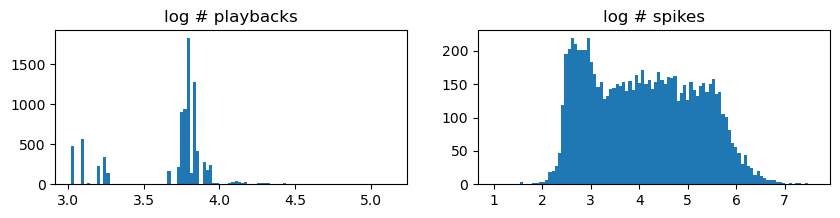

B1597 total # merged units: 8711


In [85]:
for bird, timestamp, sorter in tqdm(birds):
    spikesorting_folder = (DATA_DIR
                / "spikesorting"
                / bird
                / timestamp)
    recording_summary_df = pd.read_pickle(spikesorting_folder/ 'recording_df.pickle')

    # get units that are to be merged
    merged_units = pd.read_pickle(spikesorting_folder / 'unit_clusters2.pickle')
    merged_units = merged_units.sort_values(by='n_playbacks', ascending=False)
    merged_units = merged_units[merged_units.n_playbacks.astype('float')  > min_playbacks]
    
    plot = True
    if plot:
        fig, axs = plt.subplots(ncols=2, figsize=(10,2))
        axs[0].hist(np.log10(merged_units.n_playbacks.values.astype('float')+1), bins = 100);
        axs[0].set_title('log # playbacks')
        axs[1].hist(np.log10(merged_units.n_spikes.values.astype('float')+1), bins = 100);
        axs[1].set_title('log # spikes')
        plt.show()
        print('{} total # merged units: {}'.format(bird, len(merged_units)))

    ensure_dir(spikesorting_folder / 'unit_statistics' / statistics_timestamp)
    break
    Parallel(n_jobs = 44, verbose=10)(
        delayed(get_unit_statistic)(
            unit_to_analyze,
            spikesorting_folder,
            statistics_timestamp,
            recompute=True,
            parallel=True,
            n_interp_point_bins=16,
            exclude_non_responses=True,
            passive=False
                    )
        for uniti, unit_to_analyze in tqdm(
            merged_units.iterrows(), desc="unit", total=len(merged_units)
        )
    );

In [54]:
bird

'B1248'

### Debugging

In [50]:
breakme

NameError: name 'breakme' is not defined

In [86]:
np.where(merged_units.cluster_id == 6270)

(array([1436]),)

In [95]:
Parallel(n_jobs=1, verbose=10)(
    delayed(get_unit_statistic)(
        unit_to_analyze,
        spikesorting_folder,
        statistics_timestamp,
        recompute=True,
        parallel=False,
        save=False,
        plot=False,
    )
    for uniti, unit_to_analyze in tqdm(
        merged_units[1436:]
        .iterrows(), desc="unit", total=len(merged_units)
    )
)

unit:   0%|          | 0/8711 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


unit spike trains:   0%|          | 0/2 [00:00<?, ?it/s]

interpolation:   0%|          | 0/9 [00:00<?, ?it/s]

cue:   0%|          | 0/8 [00:00<?, ?it/s]

NameError: name 'breakme' is not defined

### make dataframe

In [55]:
ensure_dir(DATA_DIR / 'unit_statistics' / statistics_timestamp / identifier)

In [56]:
def read_and_unit(i, metric="cosine", shuffled=True):
    try:
        df = pd.read_pickle(i)
        df['unit'] = i.stem
        df = df[(df.metric == metric) & (df.shuffled == shuffled)]
        return df
    except:
        return

In [59]:
for metric in ["cosine", "euclidean"]:
    for shuffled in [False, True]:
        for bird, timestamp, sorter in tqdm(birds[8:]):
            print(bird)
            spikesorting_folder = DATA_DIR / "spikesorting" / bird / timestamp
            recording_summary_df = pd.read_pickle(
                spikesorting_folder / "recording_df.pickle"
            )

            unit_series_save_loc = (
                spikesorting_folder
                / "unit_statistics"
                / statistics_timestamp
                / identifier
            )
            unit_pickles = list(unit_series_save_loc.glob("*.pickle"))
            if len(unit_pickles) == 0:
                print("\t no units")
                continue

            usdf = Parallel(n_jobs=-1, prefer="threads")(
                delayed(read_and_unit)(i, metric=metric, shuffled=shuffled)
                for i in tqdm(unit_pickles, leave=False, desc="reading pickles")
            )

            unit_statistics_df = pd.concat(
                usdf,
                axis=0,
            )
            ensure_dir(
                DATA_DIR
                / "unit_statistics"
                / statistics_timestamp
                / (identifier + "_{}_{}".format(metric, shuffled))
            )
            unit_statistics_df.to_pickle(
                DATA_DIR
                / "unit_statistics"
                / statistics_timestamp
                / (identifier + "_{}_{}".format(metric, shuffled))
                / "{}.pickle".format(bird)
            )

  0%|          | 0/2 [00:00<?, ?it/s]

B1593


reading pickles:   0%|          | 0/7714 [00:00<?, ?it/s]

B1248


reading pickles:   0%|          | 0/8698 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

B1593


reading pickles:   0%|          | 0/7714 [00:00<?, ?it/s]

B1248


reading pickles:   0%|          | 0/8698 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

B1593


reading pickles:   0%|          | 0/7714 [00:00<?, ?it/s]

B1248


reading pickles:   0%|          | 0/8698 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

B1593


reading pickles:   0%|          | 0/7714 [00:00<?, ?it/s]

B1248


reading pickles:   0%|          | 0/8698 [00:00<?, ?it/s]

In [58]:
unit_statistics_df[:3]

,interp,cue,metric,sm,sm_n,shuffled,unit
24,AF,CL,euclidean,"[[0.07815383711506421, 0.0911404051323169, 0.0...","[[28.0, 96.0, 40.0, 128.0, 48.0, 72.0, 8.0, 56...",True,40
25,AF,CR,euclidean,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,40
26,AF,CR1,euclidean,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,40


In [ ]:
len(unit_statistics_df)

In [ ]:
unit_statistics_df[:3]

In [ ]:
unit_series_save_loc